In [1]:
# @title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here", "setup.py"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex tfds-nightly tf-nightly tensor-sensor[jax] einops")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

### Package Preamble

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
import chex

config.update("jax_enable_x64", False)

# datasets
import tensorflow_datasets as tfds

import numpy as np
from functools import partial
from sklearn.preprocessing import StandardScaler

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Data

We're going to using the MNIST dataset. It's a simple dataset with a single channel image and `28x28`. So overall it's `60Kx28x28x1`.

We're going to use the `numpy` standard for the images.

`B,H,W,C`

where:
* `B` - batch size
* `H` - height 
* `W` - width
* `C` - channels


In [187]:
ds

<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [217]:
%%time
import tensorflow as tf

# DATA, CIFAR10
ds, ds_info = tfds.load('mnist', split='train', as_supervised=True, shuffle_files=True, with_info=True)

CPU times: user 41.6 ms, sys: 133 µs, total: 41.7 ms
Wall time: 41.1 ms


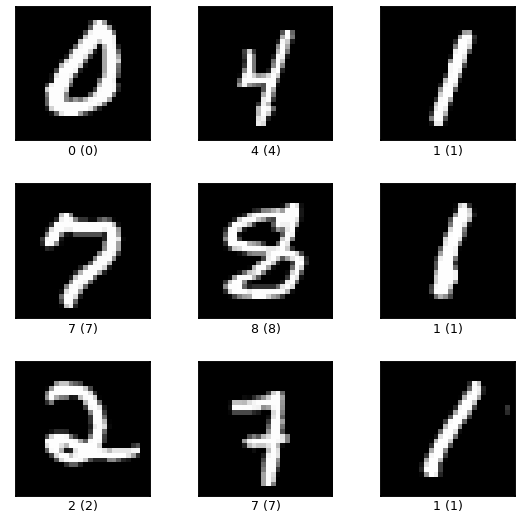

In [218]:
fig = tfds.show_examples(ds, ds_info)

In [219]:
# normalize images
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label


ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

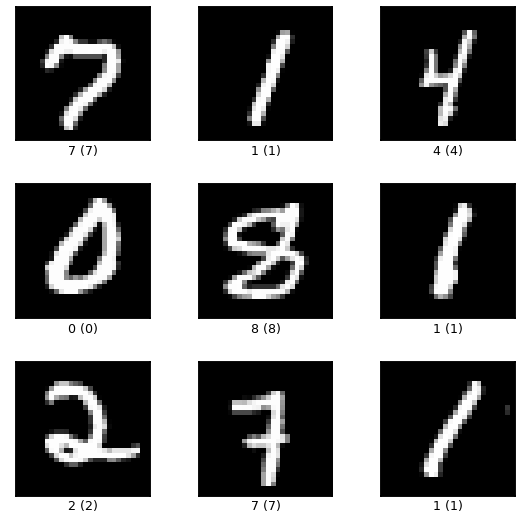

In [220]:
fig = tfds.show_examples(ds, ds_info)

In [192]:
# take some examples
B = 10

# take 10 samples from the dataset
ds_sample = ds.take(B)

# extract all images
X = [x[0] for x in tfds.as_numpy(ds_sample)]

# stack them in a new batch axes
X = np.stack(X).astype(np.float32)

# add some noise
X *= np.random.rand(*X.shape)
X.shape

(10, 28, 28, 1)

## Reshaping

In [193]:
# define filter shape
filter_shape = (2, 2)

fh, fw = filter_shape

# new shapes
Hn = H // fh
Wn = W // fw

# extract shape
B, H, W, C = X.shape

In [194]:
# refactor in a nicer way
from einops import rearrange

#### Forward Reshape

1. Factor spatial dimension

$$
\text{B} \times \text{H} \times \text{W} \times \text{C} \rightarrow
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}} \times fh \times \frac{\text{W}}{\text{fw}} \times fw 
$$

2. Transpose

$$
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}} \times fh \times \frac{\text{W}}{\text{fw}} \times fw 
\rightarrow
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}}  \times \frac{\text{W}}{\text{fw}} \times fh \times fw
$$

3. Aggregate Spatial Dim factors into channels

$$
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}} \times fh \times \frac{\text{W}}{\text{fw}} \times fw 
\rightarrow
\left( \text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}}  \times \frac{\text{W}}{\text{fw}} \right) \times \left( fh \times fw \right)
$$


In [195]:
X_ms = rearrange(X, "B (Hn fh) (Wn fw) C -> (B C Hn Wn) (fh fw)", fh=fh, fw=fw)
X_ms.shape

(1960, 4)

#### Inverse Reshape



1. Aggregate Spatial Dim factors into channels

$$
\left( \text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}}  \times \frac{\text{W}}{\text{fw}} \right) \times \left( \text{fh} \times \text{fw} \right)
\rightarrow
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}} \times \text{fh} \times \frac{\text{W}}{\text{fw}} \times \text{fw} 
$$

2. Transpose

$$
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}}  \times \frac{\text{W}}{\text{fw}} \times \text{fh} \times \text{fw}
\rightarrow
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}} \times \text{fh} \times \frac{\text{W}}{\text{fw}} \times \text{fw}
$$

3. Factor spatial dimension

$$
\text{B} \times \text{C} \times \frac{\text{H}}{\text{fh}} \times \text{fh} \times \frac{\text{W}}{\text{fw}} \times \text{fw} 
\rightarrow
\text{B} \times \text{H} \times \text{W} \times \text{C} 
$$

In [196]:
X_approx = rearrange(
    X_ms,
    "(B C Hn Wn) (fh fw) -> B (Hn fh) (Wn fw) C",
    B=B,
    C=C,
    Hn=Hn,
    Wn=Wn,
    fh=fh,
    fw=fw,
)

# assert they're the same
np.testing.assert_array_equal(X_approx, X)

## Reshape Layer

In [197]:
from typing import Tuple, Optional
from jax.random import PRNGKey
from chex import Array, dataclass


def ReshapeMultiscale(filter_shape=Tuple[int, int]):
    def init_func(rng: PRNGKey, shape, **kwargs):
        _, H, W, C = shape

        # extract coordinates
        fh, fw = filter_shape

        # check for no remainders
        assert H % fh == 0
        assert W % fw == 0

        # new shapes
        Hn = H // fh
        Wn = W // fw

        def forward_and_log_det(params: dataclass, inputs: Array, **kwargs):

            # batch size is independent

            B, *_ = inputs.shape

            # forward rearrange
            outputs = rearrange(
                inputs,
                "B (Hn fh) (Wn fw) C -> (B C Hn Wn) (fh fw)",
                B=B,
                C=C,
                Hn=Hn,
                Wn=Wn,
                fh=fh,
                fw=fw,
            )

            # logdet empty
            log_det = jnp.zeros_like(outputs)

            return outputs, log_det

        def inverse_and_log_det(params: dataclass, inputs: Array, **kwargs):

            outputs = rearrange(
                inputs,
                "(B C Hn Wn) (fh fw) -> B (Hn fh) (Wn fw) C",
                B=B,
                C=C,
                Hn=Hn,
                Wn=Wn,
                fh=fh,
                fw=fw,
            )

            # logdet empty
            log_det = jnp.zeros_like(outputs)
            return outputs, log_det

        return (), forward_and_log_det, inverse_and_log_det

    return init_func

### Demo

In [198]:
# layer params
filter_shape = (2, 2)
key = jax.random.PRNGKey(123)

# initialize layer
reshape_layer = ReshapeMultiscale(filter_shape)

# initialize params and functions
_, f, inv_f = reshape_layer(key, X.shape)

#### Forward

In [199]:
X_ms_l1, _ = f((), X)
X_ms_l1.shape

(1960, 4)

#### Inverse

In [200]:
X_approx, _ = inv_f((), X_ms_l1)
X_approx.shape

(10, 28, 28, 1)

## RBIG Transformation

In [201]:
from rbig_jax.transforms.rotation import InitPCARotation
from rbig_jax.transforms.histogram import InitUniHistUniformize
from rbig_jax.transforms.block import InitRBIGBlock

In [310]:
# take some examples
B = 10_000

# take 10 samples from the dataset
ds_sample = ds.take(B)

# extract all images
X = [x[0] for x in tfds.as_numpy(ds_sample)]

# stack them in a new batch axes
X = np.stack(X)

# normalize
from sklearn.preprocessing import StandardScaler

X = X.reshape(-1, 1)

X = StandardScaler().fit_transform(X)

X = X.reshape((B, 28, 28, 1))

# add some noise
X *= np.random.rand(*X.shape)
X.shape

(10000, 28, 28, 1)

### Transformation

In [311]:
# layer params
filter_shape = (2, 2)
key = jax.random.PRNGKey(123)

# initialize layer
reshape_layer = ReshapeMultiscale(filter_shape)

# initialize params and functions
_, f_l1, inv_f_l1 = reshape_layer(key, X.shape)

X_ms_l1, _ = f_l1((), X)
X_ms_l1.shape

(1960000, 4)

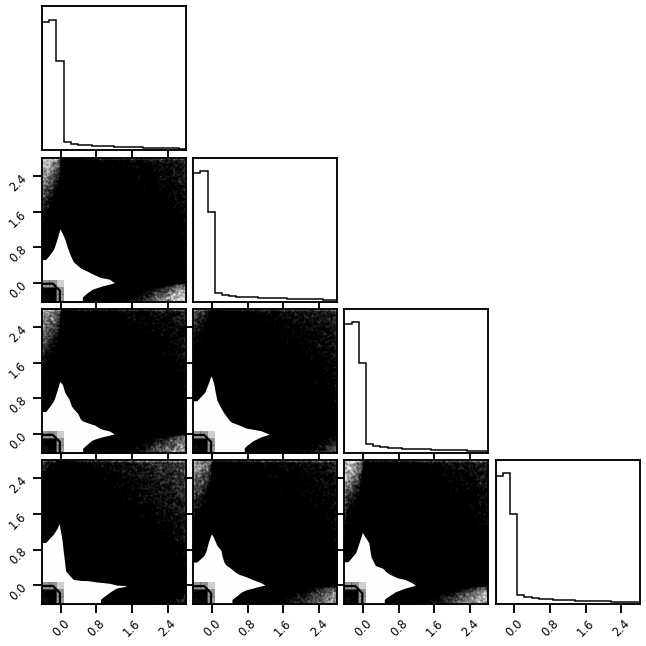

In [312]:
fig = corner.corner(X_ms_l1)

### Model

In [313]:
support_extension = 10
alpha = 1e-5
precision = 100
nbins = 100


# initialize histogram transformation
uni_uniformize = InitUniHistUniformize(
    n_samples=X_ms_l1.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha,
)

# initialize rotation transformation
rot_transform = InitPCARotation()

# initialize marginal gaussianization
eps = 1e-5

fit_transform_func, forward_f, grad_f, inverse_f = InitRBIGBlock(
    uni_uniformize, rot_transform, eps
)

# optional, compiles the function to make it faster
fit_transform_func_jitted = jax.jit(fit_transform_func)
forward_f_jitted = jax.jit(forward_f)
grad_f_jitted = jax.jit(grad_f)
inverse_f_jitted = jax.jit(inverse_f)

In [314]:
%%time

n_layers = 30
params = []
losses = []
ilayer = 0
X_g = X_ms_l1



while ilayer < n_layers:
    
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
        
    # increment
    ilayer += 1
    
    params.append(layer_params)

CPU times: user 3.59 s, sys: 2.43 ms, total: 3.59 s
Wall time: 3.58 s


In [315]:
import corner

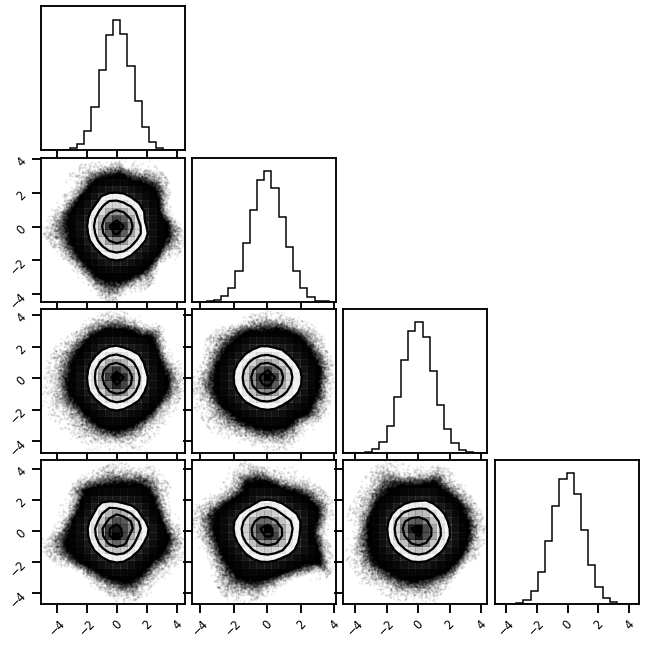

In [316]:
fig = corner.corner(X_g)

In [317]:
# inverse transform
X_g_ms_l2, _ = inv_f_l1((), X_g)

In [318]:
# layer params
filter_shape = (4, 4)
key = jax.random.PRNGKey(123)

# initialize layer
reshape_layer = ReshapeMultiscale(filter_shape)

# initialize params and functions
_, f_l2, inv_f_l2 = reshape_layer(key, X.shape)

X_ms_l2, _ = f_l2((), X_g_ms_l2)
X_ms_l2.shape

(490000, 16)

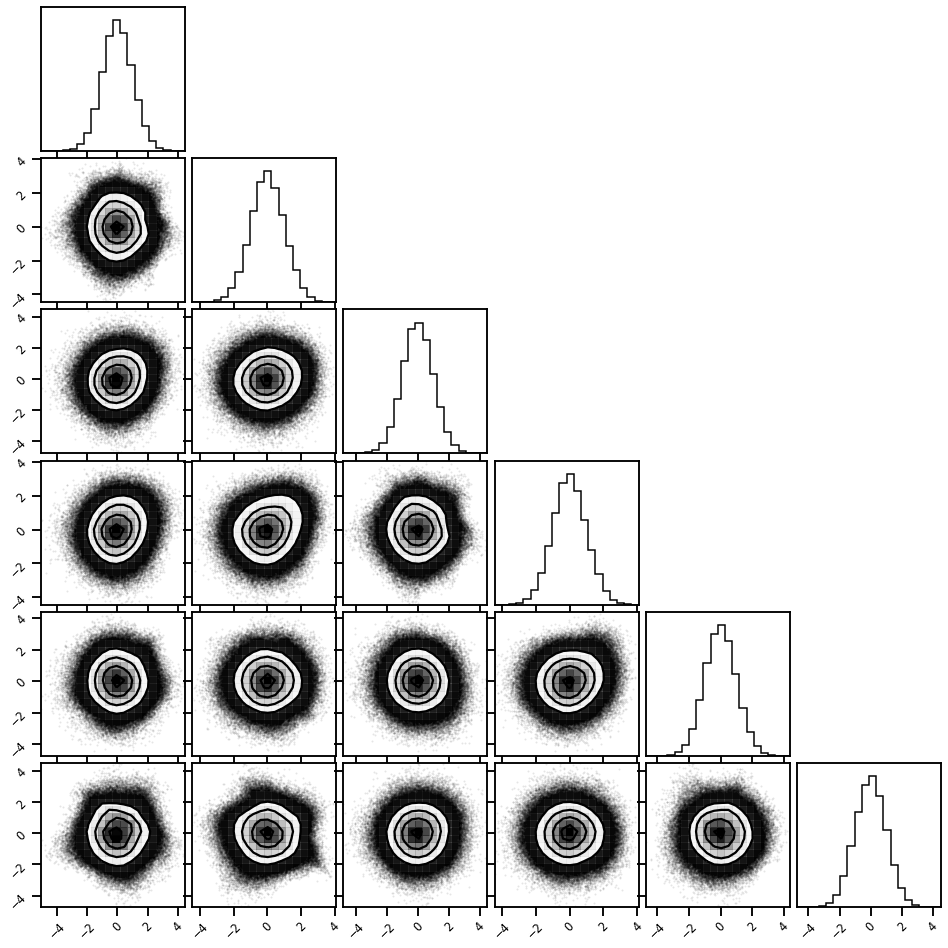

In [323]:
fig = corner.corner(X_ms_l2[:, :6])

In [320]:
%%time

n_layers = 10
params = []
losses = []
ilayer = 0
X_g = X_ms_l2



while ilayer < n_layers:
    
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
        
    # increment
    ilayer += 1
    
    params.append(layer_params)

CPU times: user 3.37 s, sys: 643 µs, total: 3.37 s
Wall time: 3.36 s


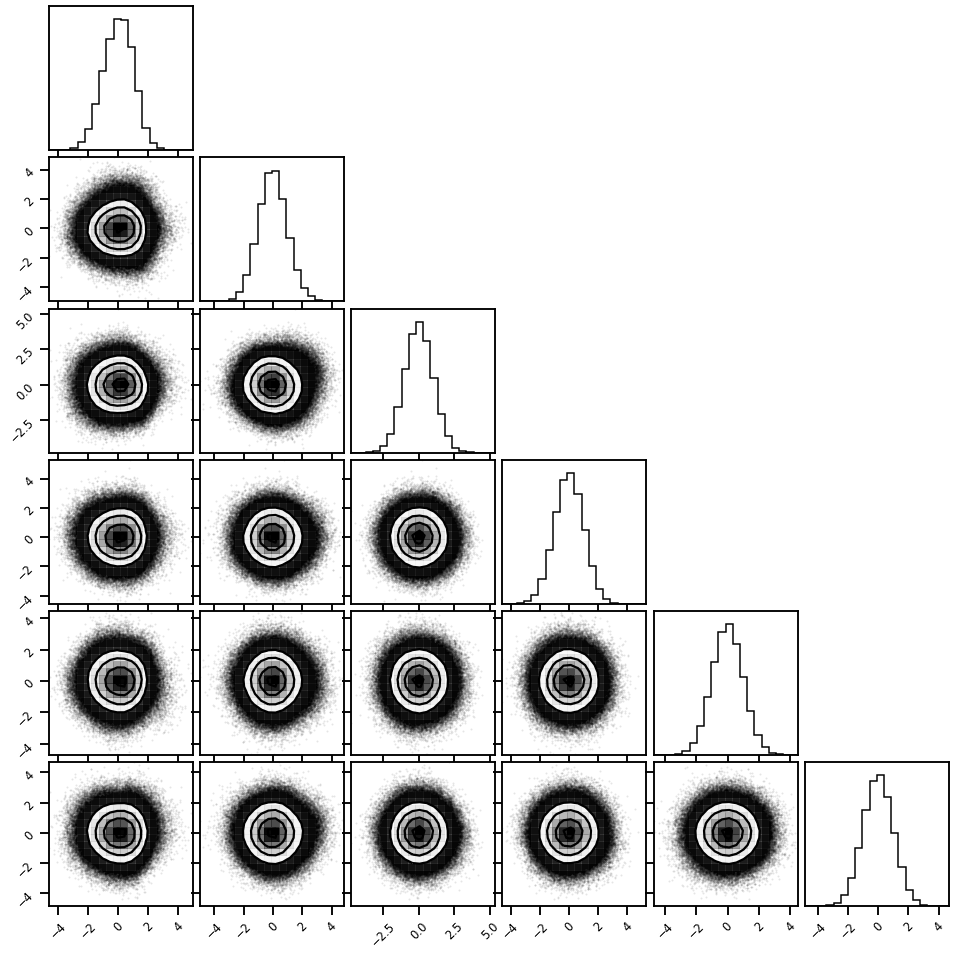

In [322]:
fig = corner.corner(X_g[:, :6])

## Multiple Levels

In [286]:
# layer params
filter_shapes = [(2, 2), (4, 4), (7, 7), (14, 14), (28, 28)]
key = jax.random.PRNGKey(123)

# initialize layer
reshape_layer = ReshapeMultiscale((28, 28))

# initialize params and functions
_, f, inv_f = reshape_layer(key, .shape)

X_ms_l1, _ = f((), X_ms_l1)
X_ms_l1.shape

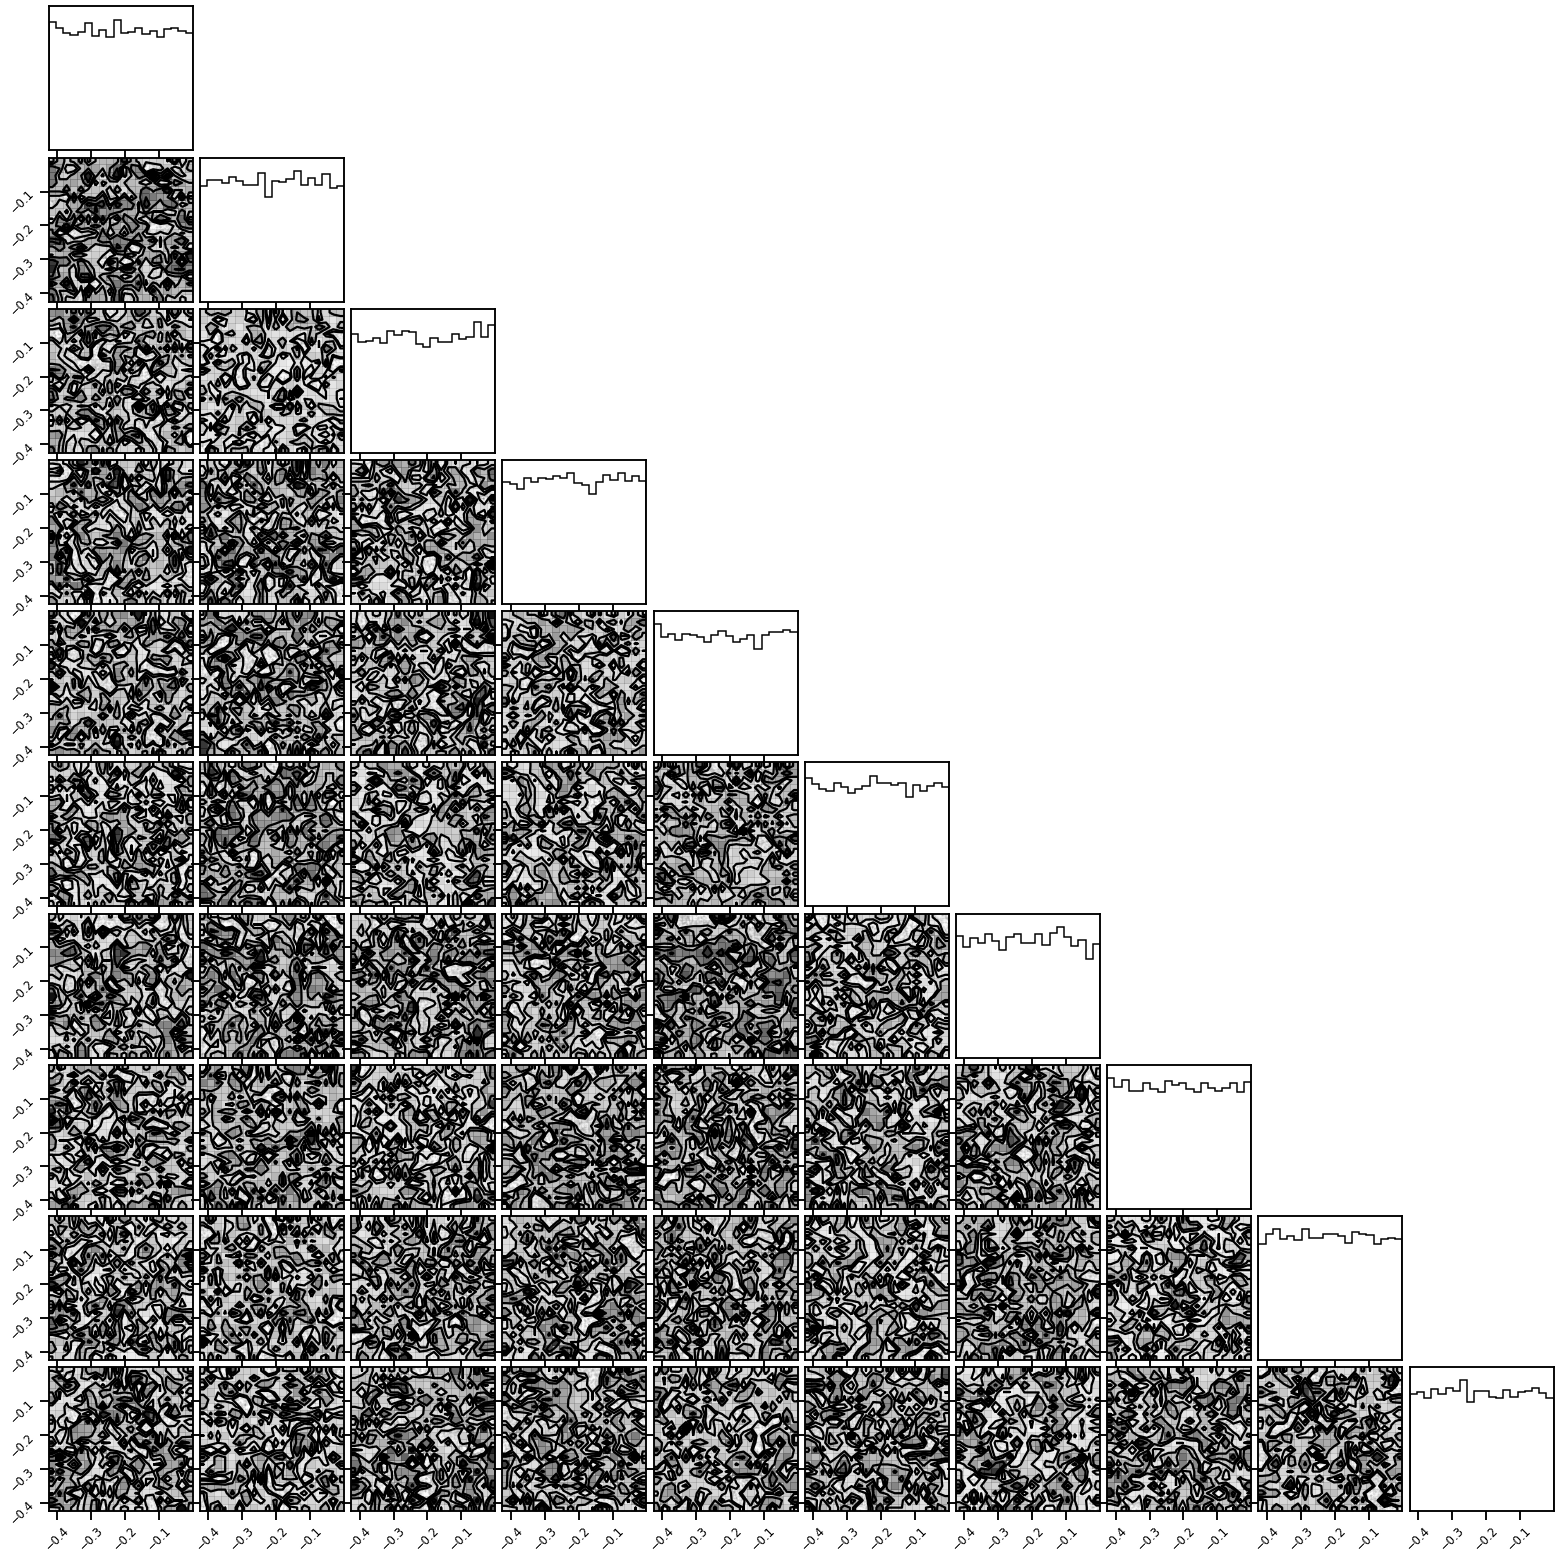

In [355]:
fig = corner.corner(X.reshape((B, 28 * 28 * 1))[:, :10])

Multiscale Level: 5, Filter: (28, 28), Size: (10_000,784): 100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


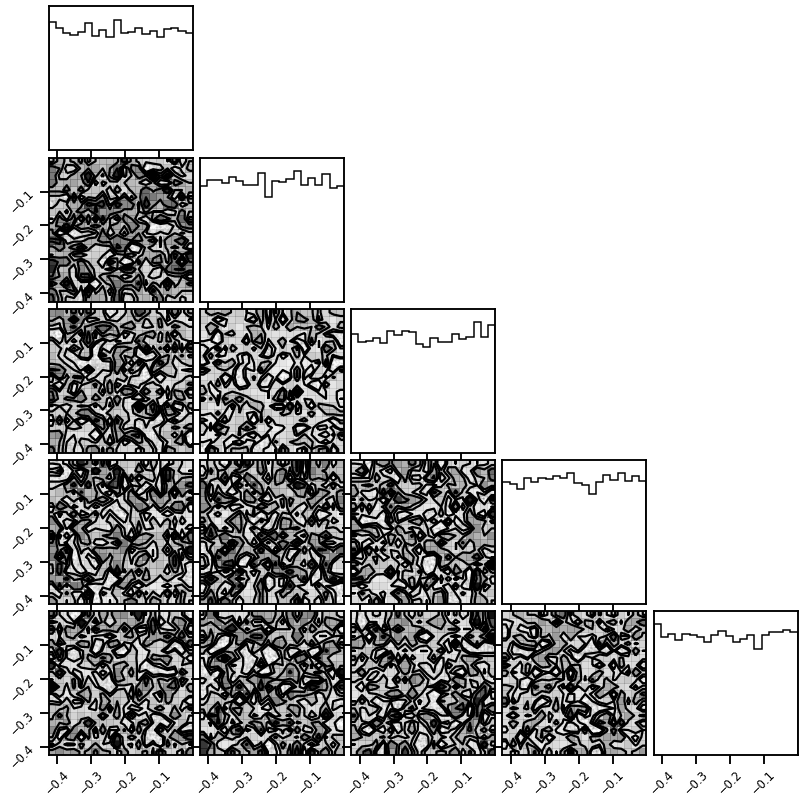

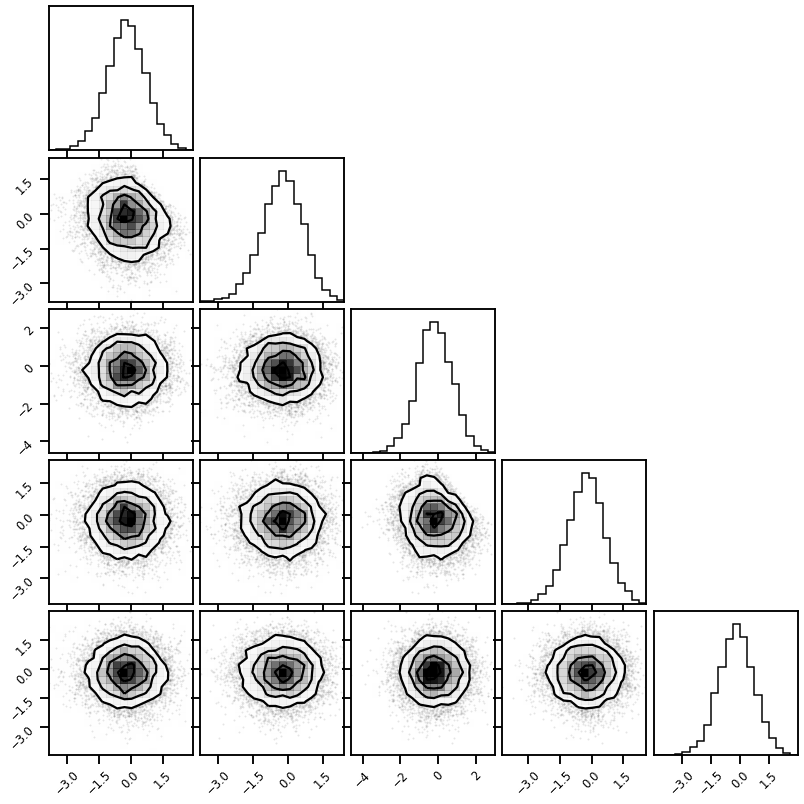

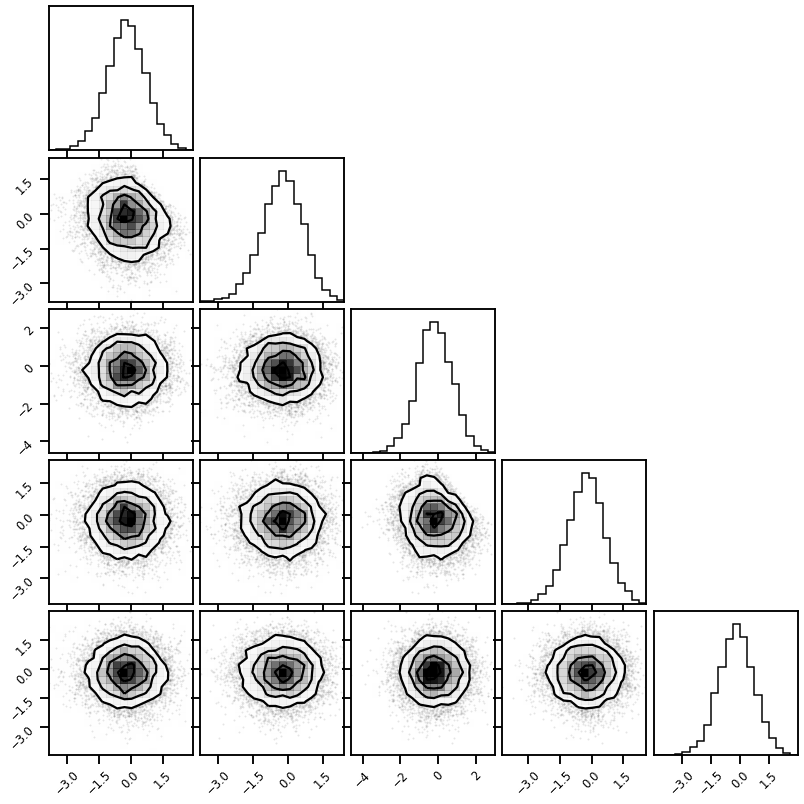

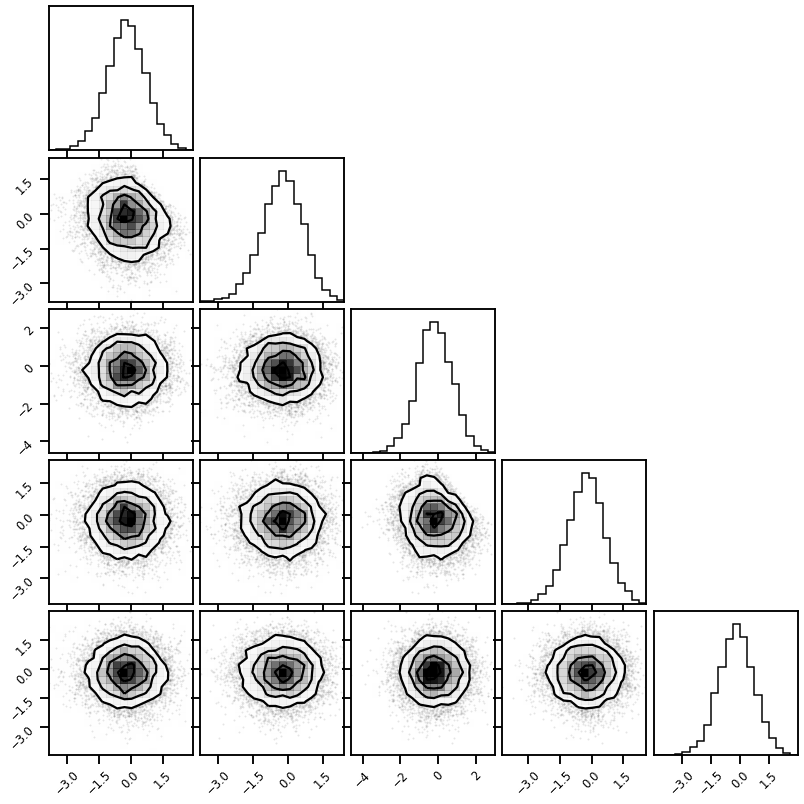

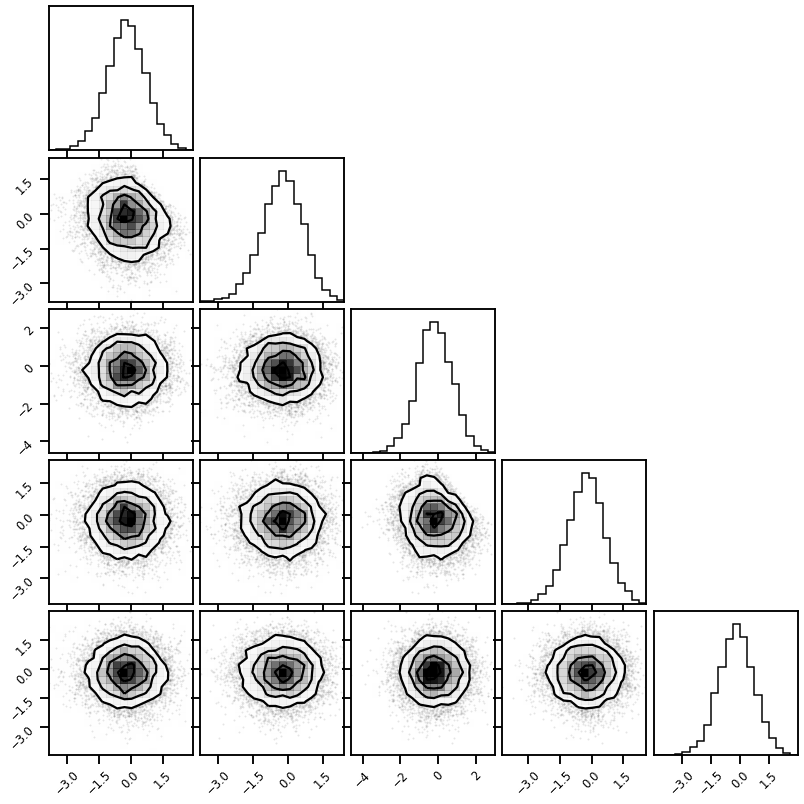

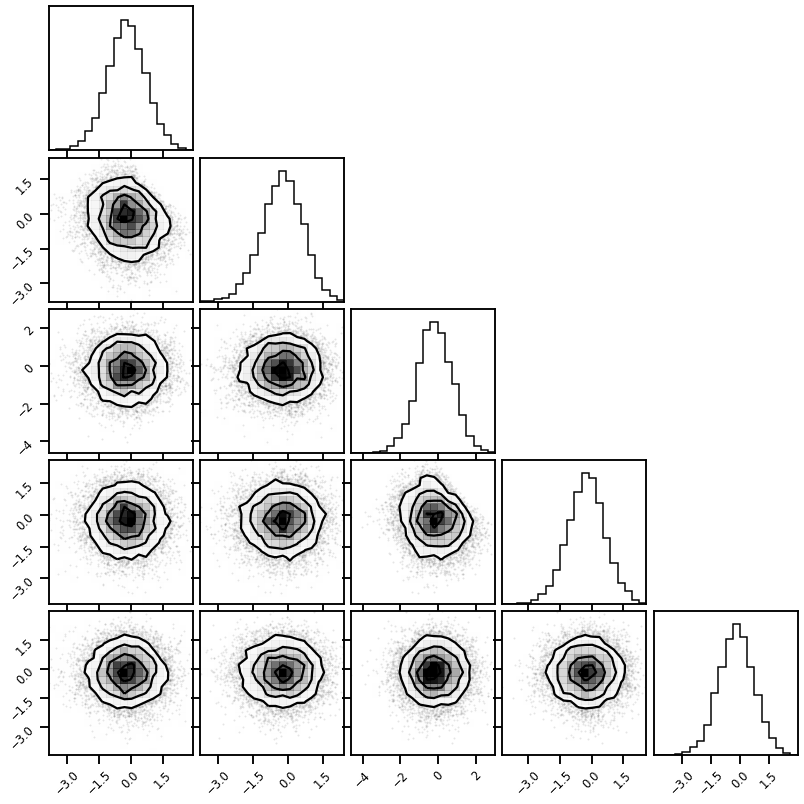

In [358]:
n_layers = 30
params = []
losses = []
ilayer = 0
X_g = X
fig = corner.corner(X_g.reshape((B, 28 * 28 * 1))[:, :5])

with tqdm.tqdm(filter_shapes) as pbar:

    for i_mscale, ifilter in enumerate(pbar):

        #         pbar.set_description(f"Multiscale Level: {i_mscale+1}, Filter: {ifilter}")

        # initialize layer
        reshape_layer = ReshapeMultiscale(ifilter)

        # initialize params and functions
        _, f, inv_f = reshape_layer((), X.shape)

        # save functions
        ms_params = {"reshape_f": f, "reshape_invf": inv_f}

        # transform data
        X_g, _ = f((), X_g)

        pbar.set_description(
            f"Multiscale Level: {i_mscale+1}, Filter: {ifilter}"
            f", Size: ({X_g.shape[0]:_},{X_g.shape[1]:_})"
        )

        # Gaussianize
        layer_params = []

        while ilayer < n_layers:

            # compute
            X_g, ilayer_params = fit_transform_func_jitted(X_g)

            # increment
            ilayer += 1

            layer_params.append(ilayer_params)

        ms_params["rbig_params"] = layer_params

        # save dictionary of params
        params.append(ms_params)

        # invert multiscale
        X_g, _ = inv_f((), X_g)
        fig = corner.corner(X_g.reshape((B, 28 * 28 * 1))[:, :5])

In [345]:
X_g.shape

(10000, 28, 28, 1)

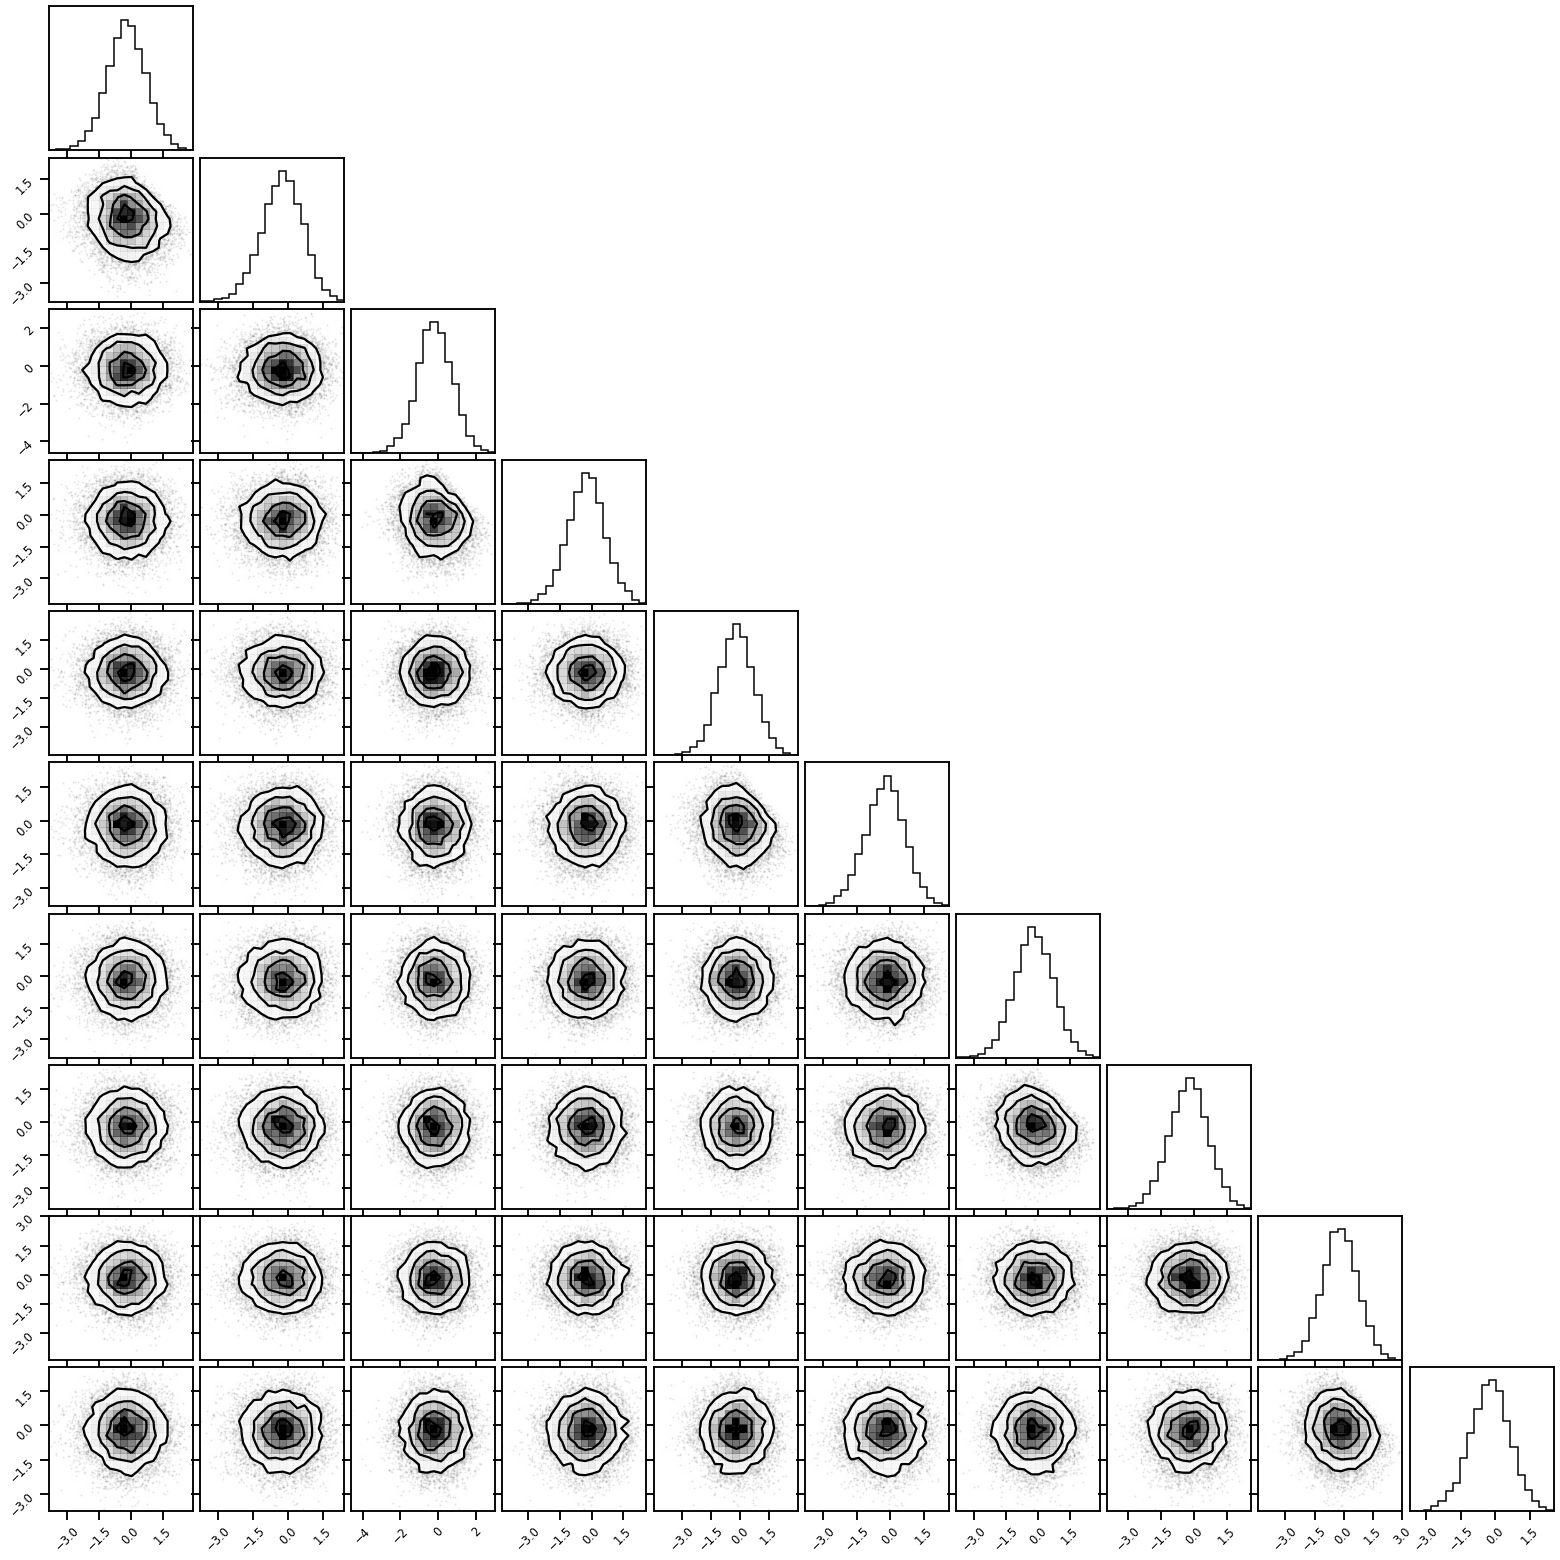

In [357]:
fig = corner.corner(X_g.reshape((B, 28 * 28 * 1))[:, :10])

In [359]:
# params

In [348]:
X_g.reshape(-2, 1).shape

TypeError: reshape new_sizes must all be positive, got (-2, 1).